# Progetto basato su conoscenza
Progetto basato su conoscenza per l'esame di Ingegneria Della Conoscenza

## 1) Introduzione

Risultati su studi che intercettano fattori di abbandono dei giochi online multigiocatore, mostrano che le motivazioni più rilevanti sono dovute da: https://www.sciencedirect.com/science/article/abs/pii/S1875952117300770

- problemi di attesa, latenza/prestazioni(più rilevanti)
- l'equità del gioco(divario tra giocatori).

### 1.1) Scenario
Si simula lo scenario in cui verrà avviato un nuovo servizio online per il lancio di un nuovo gioco multiplayer. Dato dal picco di giocatori nei primi giorni di uscita del servizio, si prevede si dovrà gestire un carico molto elevato di richieste di partecipazione da parte degli utenti. Si assume che:

- Le risorse server potrebbero risultare limitate rispetto alla popolazione di giocatori 
- Periodicamente viene fornito al sistema un numero limitato di partite istanziabili rispetto alle risorse disponibili
- Ci siano un certa popolazione di giocatori in fase di ricerca di una nuova partita
- In base a dei lavori di ricerca è stato constatato che giocatori tendono ad abbandonare la ricerca di una partita se: i giocatori attendono in coda da troppo tempo, le partite sono composte da giocatori troppo differenti rendendo il gioco squilibrato e frustrante 

### 1.2) Obiettivo
L'obiettivo di questo problema è ottimizzare al meglio l'utilizzo delle risorse(limitate), massimizzando l'efficienza dei server online per gestire al meglio il picco di giocatori atteso al lancio. Riducendo quindi il rischio di abbandono da parte dei giocatori, dovuto a lunghe attese o a partite squilibrate. Si vuole quindi sviluppare un sistema di modelli basati su conoscenza che sfrutti conoscenza pregressa già disponibile sui giocatori iscritti alla piattaforma, rispetto ai giochi precedentemente giocati.

Per favorire i criteri legati ai partecipanti. Sarà quindi fondamentale estrarre conoscenza da quella pregressa, per:
- comporre partite di giocatori chegiocando in modo simile rilevando le possibili classi naturali di giocatori(clustering)
- classificare periodicamente i nuovi giocatori rispetto alle loro statistiche affinchè vengano assegnati ad una certa classe

Un algoritmo di ricerca locale(Local Search for Optimization) costruirà l'assegnazione ottimale(CSP) che codificherà le assegnazioni dei giocatori alle partite secondo le esigenze descritte.

## 2) Dataset
Primo tentativo è stato quello ottenere i dati di statistiche tramite web scraping ma a causa del tempo limitato e del **Rate Limiting** posto dalla piattaforma ho optato per cercare un dataset già costruito(generalemente dataset di questo tipo sono rarissimi).
Il dataset è ottenuto su [https://www.kaggle.com/datasets/fahadalqahtani/cod-vanguard-stats](Kaggle), un campione di circa trecicimila tuple di statistiche su giocatori del gioco Call Of Duty Vanguard. Le features fornite sono:


- **matches**: Numero di partite multigiocatore giocate dal giocatore.
- **play_time**: Tempo totale trascorso dal giocatore giocando a Call of Duty, in ore.
- **kills**: Numero di uccisioni effettuate dal giocatore in tutte le sue partite.
- **deaths**: Numero di volte in cui il giocatore è stato ucciso nel gioco.
- **assists**: Numero di volte in cui il giocatore ha danneggiato un nemico ma un compagno di squadra ha completato l'uccisione. Un valore alto indica che altri giocatori tendono a completare o rubare l'uccisione iniziata dal giocatere.
- **headshots**: Numero di colpi alla testa inflitti ad altri giocatori.
- **suicides**: Numero di volte che il giocatore si è sucidato.
- **wins**: Numero di volte in cui il giocatore ha vinto una partita.
- **losses**: Numero totale di partite perse.
- **score**: Punti Esperienza (XP), una quantità numerica esclusiva per il multigiocatore che determina il livello e il progresso di un giocatore nel gioco.
- **missed_shots**: Numero di volte in cui il giocatore ha mancato il colpo.
- **hits_shots**: Numero di volte in cui il giocatore ha colpito un altro giocatore.


Si assume che i dati utilizzati ottenuti siano parte di conoscenza pregressa appartenente a statistiche del gioco di precedente generazione.

## 3) Pre-processing dataset conoscenza pregressa 
In questa fase si utilizzano librerie ampiamente note, per effettuare pre-processing sui dati grezzi

#### 3.1) Feature Derivation
Vengono costruite features derivate da quelle di partenza. Queste sono utili per i task successivi:
- **game_exits** = gamesPlayed - (wins + losses)
- **kd_ratio**: Rapporto uccisioni/morti, usando le features *deaths* e *kills*. Un giocatore con un valore più alto tenderà ad aver fatto molte più uccisioni che morti, contribuendo alla vittoria della partita.
[//]: #- **mh_ratio**: Rapporto colpi andati a segno/colpi non andati a segno, usando le features *hits_shots* e *missed_shots*. Un giocatore con un valore più alto tenderà a mettere a segno più colpi.

In [11]:
import pandas as pd

# carica dataset nel dataframe
df = pd.read_csv('datasets/cod_vanguard_player_stats_raw.csv')

# feature derivation
df['kd_ratio'] = df['kills'] / df['deaths']
# df['mh_ratio'] = df['hits_shots'] / df['missed_shots']
df['game_exits'] = df['matches'] - (df['wins'] + df['losses'])

#### 3.2) Data cleaning e rimozione duplicati
Questa fase di pre-processing consiste nell'applicare:
- **Data Cleaning**: Pulizia di dati con valori nulli e valori negativi(su 13 tuple ci sono 2 valori negativi probabilmente dovuti ad errori durante la raccolta dei dati). Ci sono circa 13 mila tuple, quelle difettose sono di gran lunga minori. Rimuovere le tuple problematiche non andrà ad inficiare l'informatività del dataset. 
- **Rimozione duplicati**
- **Rimozione di tuple anomale**: Visualizzando i dati in ordine noto che alcune tuple hanno valore *missed_shots* pari a zero nonostante abbiano valori molto alti in altre features, sarà ad anomalie, per cui queste tuble vengono eliminate. Non ho trovato altre anomalie.
- **Rappresentazione feature play_time**: Ricavare solo il dato numerico dei minuti totali partendo dal formato stringa hours minutes

In [12]:
# Data Cleaning - verifica dei valori mancanti
'''
print('-Verifica valori mancanti-')
print(df.isnull().sum())
'''
# rimozione valori negativi per le features
df = df[df['game_exits'] >= 0]


# rimozione duplicati
df.drop_duplicates(inplace=True)

# rimozione tuple anomale
df = df[df['missed_shots'] != 0]

# conversione stringa hours minutes in valore intero rappresentate i minuti
# funzione per convertire il formato in minuti totali
def convert_play_time_to_minutes(play_time_str):
    # split stringa
    parts = play_time_str.split(' ')
    hours = int(parts[0].replace('h', ''))
    minutes = int(parts[1].replace('m', ''))
    
    # tot minuti
    total_minutes = hours * 60 + minutes
    return total_minutes
# applicazione della funzione alla colonna "play_time" per convertire tutto in minuti
df['play_time'] = df['play_time'].apply(convert_play_time_to_minutes)


# salvataggio dataset preprocessed 
import os
file_path = 'datasets/df_preprocessed.csv'
if os.path.exists(file_path):
    os.remove(file_path)
    
df.to_csv(file_path, index=False)

#### 3.3) Outlier
Tramite boxplot delle singole features degli esempi, questi sono risultati essere coerenti con una distribuzione realistica e informativa, non ci sono valori eccessivamente anomali.

#### 3.4) Normalizzazione delle features
Una vulnerabilità del K-means è quello di essere sensibile a scale di features troppo differenti in termini di dimensioni. Si adopera quindi una tecnica di **scaling** per **standardizzazione** le features, features con scale trooppo grandi tendono a dominare. Per la normalizzazione viene usato **z-score** che trasforma la distribuzione di ogni features in una distribuzione normale standard con media 0 e deviazione standard 1. La standardizzazione(o generalmente normalizzazione) consentirà di rendere le diverse features comparabili tra loro, indipendentemente dalla loro scala originale di partenza.
Viene quindi generato un secondo dataset normalizzato per il task di apprendimento non supervisionato(K-means).

In [13]:
from sklearn.preprocessing import StandardScaler

dfPreStand = pd.read_csv('datasets/df_preprocessed.csv')

# scaling(z-score)
scaler = StandardScaler()
features_to_normalize = ['matches', 'play_time', 'kills', 'deaths', 'assists', 'headshots', 'suicides', 'wins', 'losses', 'score', 'missed_shots', 'hits_shots', 'game_exits']
dfPreStand[features_to_normalize] = scaler.fit_transform(dfPreStand[features_to_normalize])


# salvataggio del dataset per il k-means standardizzato
file_path = 'datasets/unsupervised_learning_datasets/df_standardized_preprocessed.csv'
if os.path.exists(file_path):
    os.remove(file_path)
dfPreStand.to_csv(file_path, index=False)

## 4) Apprendimento Non Supervisionato
Tramite apprendimento non supervisionato si avvalora una certa features Y non conosciuta. Quello che si vuole fare è costruire una **classificazione naturale dei dati** che non conosciamo. Tramite clustering voglio quindi partizionare l'insieme dei giocatori secondo pattern e somiglianze nei dati. Queste somiglianze devono raggruppare giocatori con comportamenti/pattern di gioco simili. 

#### 4.1)  Utilità del clustering nel problema
Specificamente al nostro problema ci servirà intercettare le *k* classi di giocatori simili, da assegnare all'insieme degli esempi. Dopo aver intercettato le k classi, durante la configurazione delle istanze delle partite di gioco, l'algoritmo di ricerca locale(CSP) utilizzerà l'informazione sulle classi per distribuire nelle partite giocatori della stessa classe, rendendole più equilibrate. L'intento e il funzionamento dell'algoritmo di ricerca viene spiegato più avanti. 

#### 4.2) Scelta approccio e algoritmo
Per rendere più flessibile la scelta dei giocatori rispetto alla classe ho valutato i due approcci Soft e Hard Clustering.

Il Soft Clustering permetterebbe di creare un sistema più flessibile in quanto ogni esempio apparterrebbe ad ogni classe con una certa distribuzione di probabilità. Rispetto agli algoritmi affrontati nel corso, però, l'algoritmo affrontato per il Soft Clustering(Expectation e Maximization) fa un'assunzione di indipendenza condizionata sulle variabili(Naive Bayes), assunzione che nel mio caso non potrei assicurare come realistica. Ho quindi optato per l'approccio'Hard Clustering utilizzando **K-means**, anche per semplificare la soluzione del problema.

#### 4.3) Scelta delle features per l'addestramento
La scelta delle features per l'addestramento non supervisionato è stata fatta in modo empirico rispetto ad assunzioni personali. L'obiettivo è stato quello di isolare le features che probabilmente riflettono lo stile di gioco dei giocatori. Le **features scelte** sono: *matches*, *play_time*, *kills*, *deaths*, *assists*, *headshots*, *score*, *missed_shots*, *hits_shots*
Il resto delle features sono state scartate per il clustering per i seguenti motivi:
- *wins* e *losses*: Sono features che dicono poco sul giocatore, in quanto le squadre sono composte da più giocatori e rifletterebbero più il risultato di una squadra

#### 4.4) Scelta del valore naturale di *K*
Un altro dettaglio da curare nel K-means è la scelta dell'iperparametro *k*, ovvero la quantità di classi con cui far lavorare l'algoritmo. Un modo per trovare il suo **valore naturale** è utilizzare la **regola del gomito**, che consiste nel partire da un certo *k* basso e incrementarlo via via, cercando il numero ottimale di cluster *k* fino a un masso di iterazioni. La regola consiste nel calcolare la **somma delle distanze quadratiche(inertia)** tra ogni esempio(punto nello spazio) e i centroidi assegnati(classe), selezionando il valore di k per il quale questa somma inizia a ridursi lentamente.

L'algoritmo verrà quindi eseguito su *k* che varierà da 1 a 11. Al metodo KMeans vengono passati i seguenti parametri:
- ***init='k-means++'***: È una tecnica di inizializzazione nella scelta i centroidi iniziali in modo più intelligente e non in modo casuale(ad esempio scegliendo centroidi distanti tra loro), questo aiuta ad innescare l'algoritmo, migliorandone la convergenza. 
- ***max_iter=300***: Rappresenta il numero massimo di iterazioni che K-means effettua durante la ricerca dei centroidi per i cluster
- ***n_init=10***: Rappresenta quanti **random restart effettuare** sulla singola scelta di k in modo da partire da diverse configurazioni di centroidi e scegliendo il miglior risultato che useremo per il calcolo dell'inertia

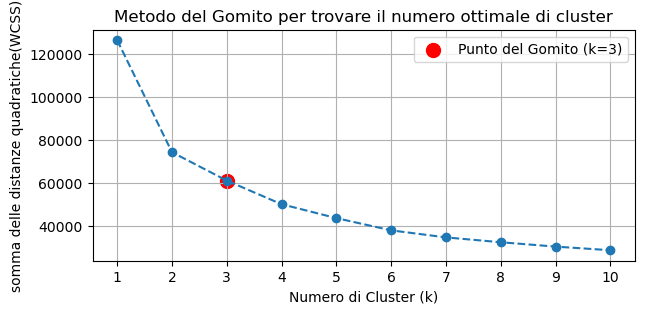

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# caricamento del dataset per il k-means standardizzato
dfPreStand = pd.read_csv('datasets/unsupervised_learning_datasets/df_standardized_preprocessed.csv')

# features usate per il clustering
featuresTocluster = ['matches', 'play_time', 'assists', 'kd_ratio', 'assists', 'headshots',
                        'score', 'missed_shots', 'hits_shots', 'suicides']
X = dfPreStand[featuresTocluster]

# vettore delle somme delle distanze quadratiche(inertia) per k che varierà nel range
wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # Inertia è il valore del WCSS per k
    
    
# Traccia il grafico della regola del gomito
plt.figure(figsize=(7, 3))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.xlabel('Numero di Cluster (k)')
plt.ylabel('somma delle distanze quadratiche(WCSS)')
plt.title('Metodo del Gomito per trovare il numero ottimale di cluster')
plt.xticks(k_range)  # Visualizza ogni valore di k sull'asse x
plt.grid(True)

# punto del gomito su k=3
plt.scatter(3, wcss[2], s=100, c='red', label='Punto del Gomito (k=3)')
plt.legend()
plt.show()

Come si può notare dopo *k=3* l'inertia diminuisce in modo meno significativo, per cui il *valore naturale*, ovvero il miglior valore è *k=4*.

#### 4.5) Assegnazione degli esempi alle classi
A questo punto trovato k, si proce con l'esecuzione del k-means con *k=4*(cluster) e si assegnano le classi agli esempi del dataset.

In [15]:
k = 3
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10)
kmeans.fit(X)


# aggiunta delle label risultanti(classi) ai dataset preprocessati
dfStandClustered = pd.read_csv('datasets/unsupervised_learning_datasets/df_standardized_preprocessed.csv')
dfClustered = pd.read_csv('datasets/df_preprocessed.csv')


# aggiunta label classe giocatore ai due dataset
dfStandClustered['cluster_label'] = kmeans.labels_
dfClustered['cluster_label'] = kmeans.labels_


# salvataggio del dataset con label sulla classe(clustering) del giocatore
file_path = 'datasets/player_class_datasets/df_stand_preproc_class_lab.csv'
if os.path.exists(file_path):
    os.remove(file_path)
dfStandClustered.to_csv(file_path, index=False)

file_path = 'datasets/player_class_datasets/df_preproc_class_lab.csv'
if os.path.exists(file_path):
    os.remove(file_path)
dfClustered.to_csv(file_path, index=False)

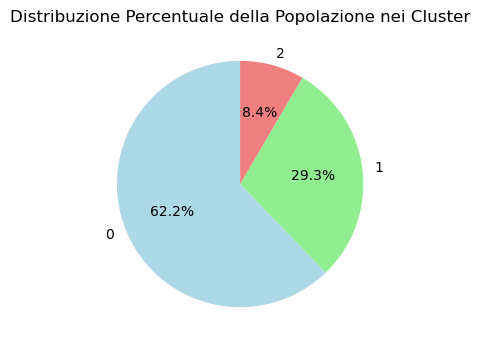

In [16]:

# Grafico a torta per mostrare la distribuzione della popolazione nei cluster
plt.figure(figsize=(4, 4))

# Conta il numero di punti in ciascun cluster
cluster_counts = dfClustered['cluster_label'].value_counts()

# Grafico a torta per mostrare la distribuzione della popolazione nei cluster
cluster_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'lightcoral'])
plt.ylabel('')
plt.title('Distribuzione Percentuale della Popolazione nei Cluster')
plt.show()

## ) Local Search for Optimization(CSP e Ricerca Locale)

L'idea è quella di rappresentare il problema dell'assegnazione delle risorse limitate tramite un algoritmo di ricerca rispetto alle assegnazioni(CSP) di variabili. 

La scelta dell'algoritmo con cui risolvere il problema è stata guidata da due considerazioni principali: 
- A causa della complessità, ovvero la crescita esponenziale dello spazio di ricerca rispetto alla quantità di giocatori disponibili e delle partite istanziabili, sarebbe inefficiente optare per un algoritmo di ricerca esaustivo, un punto di partenza potrebbe la soluzione di un CSP tramite ricerca locale. 
- Ci sono alcuni vincoli che devono essere inviolabili tramite **Hard Constraints**, come la capacità massima di giocatori in una partita
- L'algoritmo deve gestire uno scenario in cui le risorse sono limitate(partite istanziabili), consentendo il fatto che alcuni giocatori potrebbero non riuscire ad essere assegnati ad alcuna partita ovvero che i vincoli vengano soddisfati solo parzialmente. Questo potremmo codificarlo tramite **Soft Constraints**.
- L'algoritmo deve quindi cercare la soluzione ottimale soddisfando quanti più soft constraints(di cui ognuno avrà una certa importanza), consentendo la violazione di alcuni ma massimizzando l'ottimalità della soluzione usando una **funzione obiettivo**

Queste considerazioni non descrivono altro che un **Problema Di Ottimizzazione Vincolato**, per risolvere il problema ho quindi optato per un algoritmo di **Local Search for Optimization**. 

Il problema verrà codificato tramite **Hard Constraints**, **Funzione Obiettivo** e **Soft Constraints**, questi ultimi due guideranno la ricerca verso una soluzione ottimale. Una soluzione ottimale sarà ottimo locale, ovvero una soluzione di cui "ci accontenteremo" in quanto sarà impossibile stabilire se questa sarà anche un ottimo globale. Per ottenere soluzioni più soddisfacenti oltre alla scelta dell'algoritmo di ricerca adeguato, consentirò dei random restart, ma di questo ne parlo più avanti nella fase di implementazione. 

### .2) Google OR-Tools 
Per il tipo di problema di *Local Search for Optimization* ho deciso di utilizzare la libreria [Google OR-Tools](https://developers.google.com/optimization?hl=it). Questa libreria mi permette di gestire aspetti riguardanti:
- **Supporto per CSP**: OR-Tools è pensata per risolvere *Constraint Satisfaction Problems*
- **Gestione di Constraint**: consentendo sia vincoli hard che soft (vincoli hard saranno usati per gestire la capacità massima delle partite)
- **Funzione Obiettivo**: guida la ricerca di soluzioni ottimali
- **Tecniche di ricerca locale**: offrendo algoritmi di ricerca locale combinabili con *simulated annealing* e *tabu search*, affrontati durante il corso

In [10]:
#Installazione Google OR-Tools
!pip install ortools

In [11]:
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import numpy as np
import time

# modello
model = cp_model.CpModel()

### .3) Scenario simulato
Per simulare lo scenario è stata selezionata solo una porzione di giocatori dal dataset. Si simulerà lo scenario in cui le risorse messe a disposizione(match istanziabili) sono insufficienti rispetto alla richiesta di partecipazione dei giocatori. E si valuterà quanto il sistema è in grado di comporre partite che massimizzi l'efficienza del sistema, e scelga i partecipanti secondo i criteri ottimali più avanti descritti tramite soft constraints e minimizzazione della funzione obiettivo.

In [12]:
# configurazione di prova
availablePlayers = 200  # giocatori disponibili
instancesAvailableMatches = 15  # istanze partite disponibili ad essere avviate
playerCapacityMatches = 10  # capacità partite
playersClassCount = 3  # numero di classi per i giocatori

### .4) Codifica Variabili

Rispetto alle considerazioni precedenti, codifico la variabile che rappresentava l'appartenenza del giocatore come un vettore di variabili binarie il cui numero di variabili è pari al dominio della variabile codificata di partenza. La variabile che assumerà il valore 1 indicherà l'indice del server di appartenenza per il giocatore. Quindi definisco i giocatori come vettori di variabili indicatrici:

In [4]:
# definizione dei player in termini di un vettore di variabile booleane
players = []
# per ogni giocatore
for p in range(availablePlayers):
    # la variabile all'interno del vettore match con valore 1 indicherà il
    # match di appartenenza del giocatore
    matches = []
    for m in range(instancesAvailableMatches):
        # creazione di varibile booleane tanti quanti sono i match 
        matches.append(
            model.NewBoolVar(f'player_{p}_in_match_{m}')
        )
    players.append(matches)

### .5) Hard constraint


### .5.1) Problema della sommatoria di variabili con dominio non binario nella definizione di un vincolo rigido(#Sommatoria Condizionale#)


Nell'utilizzo di Google OR-Tools ho riscontrato un limite (giustificato). Nel primo tentativo, mentre progettavo le variabili e gli hard constraints da inserire, avevo deciso come scelta progettuale che ogni variabile del giocatere $P_i$(giocatore i-esimo) avrebbe rappresentato la parita a lui assegnata. Il cui dominio:

$$
P_i \quad \text{con} \quad \text{dom}(P_i) = \{ \text{numero di server istanziati} \}
$$

Una volta definite le variabili, per evitare che alle partite fossero assegnati più giocatori della loro capacità massima, ho creato un hard constraint per ogni match $M_j$ che avrebbe controllato che la somma dei giocatori assegnati a un match non superasse la capacità massima, ovvero:

$$
\left( \sum_{\substack{P_i \in \text{players} \\ \land \\ P_i = j}} 1 \right) \leq \text{playerCapacityMatches}
$$

dove `players` è il vettore dei giocatori, `j` è l'indice del match(tra i match istanziati), e `playerCapacityMatches` è la capacità massima delle partite.

### .5.1.1) Sommatoria condizionale
Questa operazione è chiamata **sommatoria condizionale** e con Google OR-Tools non è possibile costruire vincoli di sommatorie che coinvolgono variabili con domini di numeri interi (finiti). Teoricamente, per verificare un vincolo con una sommatoria condizionale, il solver dovrebbe cercare tutte le possibili assegnazioni delle variabili coinvolte nella sommatoria condizionale affinché la condizione sia soddisfatta. In teoria, si potrebbe provare tutte le possibili assegnazioni di tutte le variabili affinchè che la sommatoria condizionale sia rispettata, ma la numerosità dei domini delle variabili renderebbe la complessità del problema estremamente elevata. Anche se dal punto di vista teorico sarebbe possibile trovare un'assegnazione che soddisfi una sommatoria condizionale, la complessità in presenza di variabili con domini ampi renderebbe questa ricerca molto più difficile. Per questo motivo, l'algoritmo della libreria Google OR-Tools non consente di costruire vincoli con sommatorie condizionali in presenza di variabili con domini su più valori.

<img src="NonBooleanVariableError.png" alt="Testo Alternativo" style="width: 100%; height: auto;">

### .5.1.2) Soluzione
Consultando la documentazione e vari esempi, ho scoperto che è possibile utilizzare sommatorie condizionali nei vincoli solo se le variabili coinvolte sono **binarie**. In questo caso, la ricerca di un'assegnazione per variabili binarie non ancora assegnate che rispettino la sommatoria condizionale risulta più semplice rispetto alle variabili con domini interi. Il dominio più piccolo delle variabili binarie rende più fattibile la ricerca dell'assegnzione. Ovviamente, se il numero di variabili binarie diventa troppo elevato, il problema persisterà, ma di base la libreria utilizzata disincentiva l'utilizzo diretto delle sommatorie condizionali.


### .5.1.3) Strategia Soluzione
La strategia iniziale che stavo adottando per costruire il CSP era quella di creare una variabile $P_i$ per ogni giocatore, il cui valore avrebbe rappresentato l'indice della partita a cui appartiene.

Questa problematica mi ha portato a riprogettare la struttura delle variabili nel CSP, in cui ogni variabile viene rappresentata tramite **variabili indicatrici** rispetto al dominio della variabile di partenza. Ad esempio:
Se una variabile $Y$ ha un dominio composto da 4 elementi, allora creo 4 variabili indicatrici $(Y_1, Y_2, Y_3, Y_4)$, l'assegnazione di una di queste variabili rappresenterà l'assegnazione su $Y$. Altro dettaglio è che con l'introduzione delle variabili binarie bisogna costruire un vincolo per ogni giocatore che codifica che "solo una di queste variabili può assumere valore 1". Questo può essere rappresentato con una sommatoria condizionale sulle variabili binarie:

$$
\sum_{Y_i \in Y} Y_i \leq 1
$$

A questo punto posso costruire un vincolo di sommatoria condizionale sulle variabili binarie, più complesso ma che mi permette di codificare il vincolo che in precedenza non era possibile esprimere, risolvendo il problema di partenza.

**Nota**: Bisogna ancora codificare un vincolo aggiuntivo che garantisca che solo una variabile possa essere avvalorata(un giocatore può appartenere ad una sola istanza di partita alla volta).

### .5.3) Codifica Hard constraints
Con gli HC si definiscono dei vincoli che informano il solver su quali sono le assegnazioni sulle variabili da scartare.
#### .5.3.1) HC appartenenza partita
Per codificare l'appartenenza di un giocatore ad una partita tramite variabili binarie, bisogna introdurre un vincolo per ogni giocatore che controlla che questo appartenga al massimo ad una partita, ovvero che solo una delle variabili binarie $P_{ij}$, fissato $i$, può assumere valore pari a $1$. Questo constraint controlla che la sommatoria dei valori sulle variabili binarie su una riga siano $< 1$. Viene quindi definito un vincolo per ogni giocatore o riga(le righe rappresentano le variabili binarie di appartenenza alle partite del giocatore)

$$
\sum_{j \in \text{matches}} P_{ij} \leq 1, \quad \forall i \in \text{players}
$$

In [5]:
# si definisce un vincolo per ogni giocatore p
for p in range(availablePlayers):
    model.Add( 
        sum(players[p][m] for m in range(instancesAvailableMatches)) <= 1
    )

#### .5.3.1) HC Capacità massima partita
Risolto il problema sulla sommatoria condizionale adesso è possibile codificare il vincolo per cui ogni partita non può ospitare più giocatori della sua capacità massima. Questo viene fatto controllando che sommatoria dei valori delle signole variabili binarie di ogni giocatore appartenenti alla colonna non sia maggiore della capacità massima. Viene quindi definito un vincolo per ogni match o colonna(le colonne rappresentano i giocatori appartenenti alla partita).

$$
\sum_{i \in \text{players}} X_{ij} \leq \text{playerCapacityMatches}, \quad \forall j \in \text{matches}
$$

In [ ]:
# vincolo: il numero di giocatori per partita non deve superare la capacità massima
for m in range(instancesAvailableMatches):
    model.Add(
        sum(players[p][m] for p in range(availablePlayers)) <= playerCapacityMatches
    )

### .5) Funzione Obiettivo - Soft Constraints
Dal punto di vista teorico a differenza degli *hard Constraint*, i *soft Constraints* sono vincoli che possono essere violati, questi sono usati come criteri di preferenza sulle possibili assegnazioni ammissibili. Il **solver** generalmente deve trovare la migliore assegnazione totale seguendo queste preferenze, ovvero deve soddisfare i soft constraint nel miglior modo possibile.


### .5.1) Funzione obiettivo
Nei problemi di **ottimizzazione vincolata** i *soft Constraints* vengono spesso integrati all'interno della **funzione obiettivo** come somme di penalità o costi. L'obiettivo del problema diventa quindi trovare assegnazioni che minimizzino la funzione obiettivo(**criterio di ottimalità**). 

**Esempio:** Se si vuole massimizzare il riempimento delle partite, si può aggiungere una penalità per ogni posto vuoto nelle partite. Questa penalità viene poi sommata nella funzione obiettivo che cerca di minimizzare il valore totale.

#### .5.1.1) Costruzione termini penalità
I soft constraint selezionati(penalità) per contribuire all'ottimalità della soluzione sono:

- **Minimizzare giocatori senza partita**: I giocatori in cerca di partita dovranno cercare di essere serviti tutti


- **Massimizzare la popolazione della partita**: ovvero incentivare il riempimento delle partite, evitando di istanziare partite sottoutilizzate e quindi di utilizzare ulteriori risorse(limitate). 


- **Tempo di attesa dei giocatori in coda**: Minimizzare i giocatori non assegnati ad una partita che sono in attesa da più tempo. Questi verranno preferiti nelle assegnazioni alle partite, disincentivando l'abbandono del servizio da parte dell'utenza.


- **Partite con basso Rate quitting**:  Minimizzare nei giocatori assegnati ad una partita, i giocatori con un alto tasso di abbandono. Questo permetterà di favorire giocatori che mantengono le partite piene, inducendo quindi il pieno utilizzo delle risorse server(giocatori che abbandonano facilmente una partita, potrebbero richiedere di partecipare a nuove istanze, portando a non sfruttare pienamente le risorse). 


- **Proporzione delle partite istanziate**: La proporzione delle partite istanziate per ospitare giocatori di una certa classe deve tendere alla proporzione delle classi dei giocatori in cerca di una partita. Si può ottenere minimizzando: 


- **Partite con giocatori della stessa classe**: I giocatori appartenenti a una certa partita devono essere possibilmente della stessa classe(naturale), riducendo la possibilità che questi giocatori differiscano troppo tra loro.

Giocatori non assegnati:
Giocatore 1 non assegnato a nessuna partita
Giocatore 2 non assegnato a nessuna partita
Giocatore 3 non assegnato a nessuna partita
Giocatore 4 non assegnato a nessuna partita
Giocatore 5 non assegnato a nessuna partita
Giocatore 6 non assegnato a nessuna partita
Giocatore 7 non assegnato a nessuna partita
Giocatore 8 non assegnato a nessuna partita
Giocatore 9 non assegnato a nessuna partita
Giocatore 10 non assegnato a nessuna partita
Giocatore 11 non assegnato a nessuna partita
Giocatore 12 non assegnato a nessuna partita
Giocatore 13 non assegnato a nessuna partita
Giocatore 14 non assegnato a nessuna partita
Giocatore 15 non assegnato a nessuna partita
Giocatore 16 non assegnato a nessuna partita
Giocatore 17 non assegnato a nessuna partita
Giocatore 18 non assegnato a nessuna partita
Giocatore 19 non assegnato a nessuna partita
Giocatore 20 non assegnato a nessuna partita
Giocatore 21 non assegnato a nessuna partita
Giocatore 22 non assegnato a nessuna pa

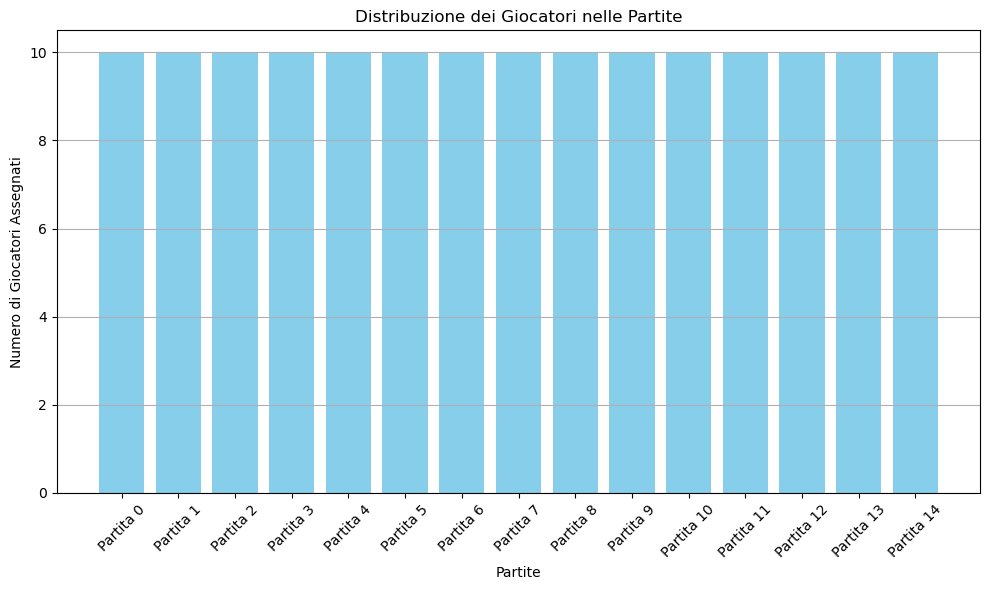

Soluzione trovata:
Partita 0: 10 giocatori assegnati
Partita 1: 10 giocatori assegnati
Partita 2: 10 giocatori assegnati
Partita 3: 10 giocatori assegnati
Partita 4: 10 giocatori assegnati
Partita 5: 10 giocatori assegnati
Partita 6: 10 giocatori assegnati
Partita 7: 10 giocatori assegnati
Partita 8: 10 giocatori assegnati
Partita 9: 10 giocatori assegnati
Partita 10: 10 giocatori assegnati
Partita 11: 10 giocatori assegnati
Partita 12: 10 giocatori assegnati
Partita 13: 10 giocatori assegnati
Partita 14: 10 giocatori assegnati


In [3]:
# variabili ausiliarie per contare il numero di giocatori assegnati a ciascuna partita
playersInMatch = [
    model.NewIntVar(0, availablePlayers, f'players_in_match_{m}')
    for m in range(instancesAvailableMatches)
]

# collegare le variabili booleane alle variabili ausiliarie per il conteggio dei giocatori
for m in range(instancesAvailableMatches):
    model.Add(playersInMatch[m] == sum(players[p][m] for p in range(availablePlayers)))

# minimizzare la penalità di riempimento incompleto (posti vuoti)
penalita_riempimento_terms = [playerCapacityMatches 
                              - playersInMatch[m] for m in range(instancesAvailableMatches)]

# minimizzare la penalità totale
model.Minimize(sum(penalita_riempimento_terms))

# solver e risoluzione
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 60.0  # limite di tempo di 60 secondi

# risolvere il problema senza callback
status = solver.Solve(model)

# output della soluzione finale
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print('Giocatori non assegnati:')
    unassigned_players = []
    assigned_players = []
    assignments = [[] for _ in range(instancesAvailableMatches)]

    for p in range(availablePlayers):
        assigned = False
        for m in range(instancesAvailableMatches):
            if solver.Value(players[p][m]) == 1:
                assigned_players.append(p)
                assignments[m].append(p)
                assigned = True
                break
        if not assigned:
            unassigned_players.append(p)
            print(f'Giocatore {p} non assegnato a nessuna partita')

    # visualizzazione grafica dei giocatori assegnati e non assegnati
    print('visualizza grafico')
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = []
    labels = []

    for m in range(instancesAvailableMatches):
        bars.append(solver.Value(playersInMatch[m]))
        labels.append(f'Partita {m}')

    x = np.arange(len(labels))
    ax.bar(x, bars, color='skyblue')
    ax.set_xlabel('Partite')
    ax.set_ylabel('Numero di Giocatori Assegnati')
    ax.set_title('Distribuzione dei Giocatori nelle Partite')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.grid(axis='y')

    plt.tight_layout()
    plt.show()

    print('Soluzione trovata:')
    for m in range(instancesAvailableMatches):
        print(f'Partita {m}: {solver.Value(playersInMatch[m])} giocatori assegnati')
else:
    print('Nessuna soluzione ottimale trovata')
